In [1]:
from google.colab import drive
drive.mount('/content/drive')
# replace this the path to the directory containing the code
%cd /content/drive/MyDrive/TransferED
# verify that you are in the right directory
! ls

Mounted at /content/drive
/content/drive/MyDrive/TransferED
'“A emotion detector based on bert-multi language”的副本.ipynb'   final_model_unfreeze_xlsr
 ESD								  Main_train.ipynb
 Explore.ipynb							  test.ipynb
 final_model_freeze_finermodel					  util
 final_model_freeze_xlsr


In [2]:
#install necessary packages and set up environment

!pip install requests==2.31.0
!pip install datasets==2.19.0 huggingface-hub==0.23.0


!pip install transformers[torch] accelerate

#!pip uninstall -y huggingface-hub
#!pip install git+https://github.com/huggingface/datasets.git
#!pip install git+https://github.com/huggingface/transformers.git
#it seems to be important to install all these before setting the environment
!pip install jiwer
!pip install torchaudio
!pip install librosa
%env LC_ALL=C.UTF-8
%env LANG=C.UTF-8
%env HF_HOME=/content/cache
%env HF_DATASETS_CACHE=/content/cache
%env CUDA_LAUNCH_BLOCKING=1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfully uninstalled requests-2.32.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.3, but you have requests 2.31.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.6 MB/s eta 0:00:00
 

In [3]:
#create extra test dataset
import importlib
import util.dataloader
importlib.reload(util.dataloader)
from util.dataloader import dfcreator, save_traindata, save_testextdata

test_extra_dirs = [
  #  "/content/drive/MyDrive/TransferED/ESD/0018",
  #  "/content/drive/MyDrive/TransferED/ESD/0019",
   # "/content/drive/MyDrive/TransferED/ESD/0020",
    "/content/drive/MyDrive/TransferED/ESD/0016"
 #  "/content/drive/MyDrive/TransferED/ESD/0002"
]

df = dfcreator(test_extra_dirs)

save_path = "/content/drive/MyDrive/TransferED/ESD"


save_testextdata(save_path,df)

1750it [01:06, 26.41it/s]


(1750, 3)


In [4]:
from datasets import load_dataset, load_metric
data_files = {
    "test_extra": "/content/drive/MyDrive/TransferED/ESD/test_extra.csv",
}

dataset = load_dataset("csv", data_files=data_files, delimiter="\t", )
test_dataset_extra = dataset["test_extra"]


print(test_dataset_extra)

Generating test_extra split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['name', 'path', 'emotion'],
    num_rows: 1750
})


In [5]:
import torch
import numpy as np
from transformers import AutoConfig, Wav2Vec2Processor, Wav2Vec2FeatureExtractor, Wav2Vec2ForSequenceClassification


import util.model

importlib.reload(util.model)
from util.model import Wav2Vec2ForSpeechClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name_or_path = "/content/drive/MyDrive/TransferED/final_model_unfreeze_xlsr"
config = AutoConfig.from_pretrained(model_name_or_path)
processor = Wav2Vec2FeatureExtractor.from_pretrained(model_name_or_path)
model = Wav2Vec2ForSpeechClassification.from_pretrained(model_name_or_path).to(device)


import util.predict

importlib.reload(util.predict)
from util.predict import Predictor

Predict = Predictor(model=model, processor=processor,config=config,device=device)

test_dataset_extra = test_dataset_extra.map(Predict.speech_file_to_array_fn)

result = test_dataset_extra.map(Predict.predict, batched=True, batch_size=8)
label_names = [config.id2label[i] for i in range(config.num_labels)]
label_names
y_true = [config.label2id[name] for name in result["emotion"]]
y_pred = result["predicted"]

print(y_true[:5])
print(y_pred[:5])

Parameter 'function'=<bound method Predictor.speech_file_to_array_fn of <util.predict.Predictor object at 0x7e7d49183700>> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/1750 [00:00<?, ? examples/s]

Map:   0%|          | 0/1750 [00:00<?, ? examples/s]

[3, 0, 3, 1, 0]
[3, 0, 3, 1, 0]


In [6]:
print(config.hidden_size)

1024


In [7]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=label_names))

              precision    recall  f1-score   support

       Angry       0.96      0.85      0.90       350
       Happy       0.73      0.95      0.82       350
     Neutral       0.88      0.81      0.84       350
         Sad       1.00      1.00      1.00       350
    Surprise       0.95      0.85      0.90       350

    accuracy                           0.89      1750
   macro avg       0.90      0.89      0.89      1750
weighted avg       0.90      0.89      0.89      1750



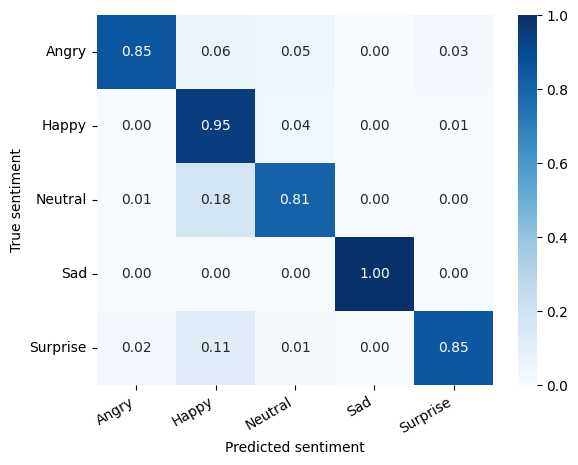

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix


def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt=".2f", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm_normalized, index=label_names, columns=label_names)
show_confusion_matrix(df_cm)